In [1]:
%load_ext autoreload
%autoreload 2
import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets


import functools

import e3x
import flax.linen as nn
import jax
import jax.numpy as jnp

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)|
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
# from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from dcmnet.data import prepare_batches, prepare_datasets

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())



[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [2]:
test_file = open("/cluster/pchem-data/meuwly/boittier/home/polardata/susceptibility_water_bulk/train.xyz")
lines = test_file.readlines()
skips = int(lines[0])+2

R = []
pol = []
Z = []

# for i in range(len(lines)//skips):
#     tmp_lines = lines[i*skips :i*skips + skips]
#     print(tmp_lines[1].split("="))
lines[0]

'96\n'

In [754]:
(epsilon - 1)

array([[[-0.20902794, -1.00303394, -1.00597447],
        [-1.00286852, -0.18097394, -0.99791942],
        [-1.00615015, -0.99771472, -0.18121108]],

       [[-0.18612144, -0.9913051 , -0.99969345],
        [-0.99096462, -0.2025413 , -0.99285715],
        [-0.99966066, -0.99282213, -0.20262998]],

       [[-0.22072752, -1.00156241, -0.99763502],
        [-1.00141674, -0.22331528, -1.00869971],
        [-0.99756497, -1.00858636, -0.22095247]],

       ...,

       [[-0.23481569, -0.99915849, -0.99230344],
        [-0.99881866, -0.18738844, -0.99281012],
        [-0.99224842, -0.99283677, -0.19655903]],

       [[-0.20968426, -1.01042493, -1.00597091],
        [-1.01031316, -0.18128274, -0.99133105],
        [-1.00594156, -0.99113562, -0.20955877]],

       [[-0.21174553, -1.0202793 , -0.99888627],
        [-1.01988101, -0.22847805, -0.98818995],
        [-0.99895139, -0.98820622, -0.22957401]]])

In [755]:
epsilon

array([[[ 7.90972056e-01, -3.03394431e-03, -5.97447117e-03],
        [-2.86852053e-03,  8.19026058e-01,  2.08058384e-03],
        [-6.15014505e-03,  2.28527515e-03,  8.18788924e-01]],

       [[ 8.13878557e-01,  8.69490103e-03,  3.06553659e-04],
        [ 9.03537981e-03,  7.97458705e-01,  7.14284978e-03],
        [ 3.39344383e-04,  7.17787160e-03,  7.97370016e-01]],

       [[ 7.79272482e-01, -1.56241406e-03,  2.36497739e-03],
        [-1.41674443e-03,  7.76684717e-01, -8.69970774e-03],
        [ 2.43502665e-03, -8.58635644e-03,  7.79047526e-01]],

       ...,

       [[ 7.65184307e-01,  8.41512383e-04,  7.69655614e-03],
        [ 1.18134427e-03,  8.12611555e-01,  7.18988483e-03],
        [ 7.75157864e-03,  7.16323373e-03,  8.03440971e-01]],

       [[ 7.90315744e-01, -1.04249320e-02, -5.97090638e-03],
        [-1.03131571e-02,  8.18717265e-01,  8.66894733e-03],
        [-5.94155790e-03,  8.86438258e-03,  7.90441232e-01]],

       [[ 7.88254471e-01, -2.02792967e-02,  1.11372598e-03],
 

In [798]:
import ase.io
atoms = ase.io.read(
    "/cluster/pchem-data/meuwly/boittier/home/polardata/susceptibility_water_bulk/train.xyz",index=":")

In [799]:
R = np.array([np.pad(_.get_positions(), ((0,1),(0,0))) for _ in atoms])
Z = np.array([np.pad(_.get_atomic_numbers(), ((0,1))) for _ in atoms])
pol =  np.array([_.info["pol"].reshape(3,3) for _ in atoms])
cell = np.array([_.cell for _ in atoms])
mu = np.array([_.info["mu"].reshape(1,3) for _ in atoms])
epsilon = np.array([_.info["epsilon"].reshape(3,3) for _ in atoms])

In [832]:
volume = (cell*0.529177).sum(axis=1).prod(axis=1)
rho = volume

In [833]:
cell[0]

array([[9.93999, 0.     , 0.     ],
       [0.     , 9.93999, 0.     ],
       [0.     , 0.     , 9.93999]])

In [834]:
train_data = {"R": R, "Z": Z, "pol": epsilon, "cell": cell, "mu":mu, "epsilon": epsilon}


In [334]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [335]:
import jax_md
from jax_md import space
from jax_md import smap
from jax_md import energy
from jax_md import quantity
from jax_md import simulate
from jax_md import partition

In [336]:
jax.vmap

<function jax._src.api.vmap(fun: 'F', in_axes: 'int | None | Sequence[Any]' = 0, out_axes: 'Any' = 0, axis_name: 'AxisName | None' = None, axis_size: 'int | None' = None, spmd_axis_name: 'AxisName | tuple[AxisName, ...] | None' = None) -> 'F'>

In [84]:
format = partition.Sparse
dst_idx = []
src_idx = []
dists = []
for i in tqdm(range(len(R))):
    side_length = cell[i].sum(axis=0)
    displacement, shift = space.periodic(side_length)
    neighbor_fn, _ = energy.lennard_jones_neighbor_list(displacement, 
                                                                side_length,
                                                                format=format)
    nbrs = neighbor_fn.allocate(R[i][:96])
    _dst_idx = nbrs.idx[0]
    _src_idx = nbrs.idx[1]

    r = jnp.array(R[i])
    def comp_dist(i, j):
        return displacement(r[i], r[j])
    _dists = jax.vmap(comp_dist)(_dst_idx, _src_idx)

    dst_idx.append(_dst_idx)
    src_idx.append(_src_idx)
    dists.append(_dists)
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:34<00:00,  2.34it/s]


In [112]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)

max_occupancy = [len(_) for _ in dst_idx]
dst_idx = [np.pad(dst_idx[i], (0, max(max_occupancy) - len(dst_idx[i])), constant_values=(96)) 
           for i in range(len(dst_idx))]
src_idx = [np.pad(src_idx[i], (0, max(max_occupancy) - len(src_idx[i])), constant_values=(96))  
           for i in range(len(src_idx))]

dists = np.array([np.pad(dists[i], ((0, max(max_occupancy) - len(dists[i])), (0,0))).squeeze() 
           for i in range(len(dists))])

dst_idx=np.array(dst_idx) 
src_idx=np.array(src_idx) 

In [216]:
dists[0].shape, dists[1].shape

((3120, 3), (3120, 3))

In [835]:
train_data = {"R": R[:450], "Z": Z[:450], "pol": epsilon[:450], 
              "cell": cell[:450], "mu":mu[:450], "epsilon": epsilon[:450], "dists": dists[:450],
             "src_idx": src_idx[:450], "dst_idx": dst_idx[:450]}
valid_data = {"R": R[450:], "Z": Z[450:], "pol": epsilon[450:], 
              "cell": cell[450:], "mu":mu[450:], "epsilon": epsilon[450:], "dists": dists[450:],
             "src_idx": src_idx[450:], "dst_idx": dst_idx[450:]}

In [836]:
class POLAR(nn.Module):
    features: int = 32
    max_degree: int = 4
    num_iterations: int = 1
    num_basis_functions: int = 32
    cutoff: float = 6.0
    max_atomic_number: int = 8
    include_pseudotensors: bool = True
    def mono(
        self, atomic_numbers, positions, dst_idx, src_idx, dists, batch_segments, batch_size
    ):
        # 1. Calculate displacement vectors.
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = dists.squeeze() #positions_src - positions_dst  # Shape (num_pairs, 3).

        # 2. Expand displacement vectors in basis functions.
        basis = e3x.nn.basis(
            # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff),
        )

        x = e3x.nn.Embed(
            num_embeddings=self.max_atomic_number + 1, features=self.features
        )(atomic_numbers)

        # 4. Perform iterations (message-passing + atom-wise refinement).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Final iteration.
                y = e3x.nn.MessagePass(
                    max_degree=self.max_degree, include_pseudotensors=False
                )(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            else:
                y = e3x.nn.MessagePass(include_pseudotensors=self.include_pseudotensors)(
                    x, basis, dst_idx=dst_idx, src_idx=src_idx
                )
            y = e3x.nn.add(x, y)
            # Atom-wise refinement MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features)(y)
            # Residual connection.
            x = e3x.nn.add(x, y)

        x = e3x.nn.TensorDense(
            features=self.features,
            max_degree=2,
            include_pseudotensors=False,
        )(x)
              
        x = jnp.sum(x[..., 0, :, 0], axis=-2)  # Shape (..., (max_degree+1)**2).
        # 4. Convert output irreps to 3x3 matrix and return.
        cg = e3x.so3.clebsch_gordan(max_degree1=1, max_degree2=1, max_degree3=2)  # Shape (4, 4, 9).
        y = jnp.einsum('...l,nml->...nm', x, cg[1:, 1:, :])  # Shape (..., 3, 3).
        return y

    @nn.compact
    def __call__(
        self,
        atomic_numbers,
        positions,
        dst_idx,
        src_idx,
        dists,
        batch_segments=None,
        batch_size=None,
    ):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1

        return self.mono(
            atomic_numbers, positions, dst_idx, src_idx, dists, batch_segments, batch_size
        )

In [837]:
import functools

import jax
import jax.numpy as jnp
import numpy as np
import optax
from jax.random import randint

from dcmnet.electrostatics import batched_electrostatic_potential, calc_esp
from dcmnet.modules import NATOMS
from dcmnet.utils import reshape_dipole


def polar_loss(a, b):
    l2_loss = optax.l2_loss(a, b.squeeze()) * 2
    loss = np.mean(l2_loss) ** 0.5
    return loss


In [838]:
import functools
import pickle

import e3x
import jax
import jax.numpy as jnp
import optax
from dcmnet.loss import dipo_esp_mono_loss
from dcmnet.data import prepare_batches, prepare_datasets

import jax
import jax.numpy as jnp
import optax
from collections import deque
from typing import Dict, Optional, Literal


def clip_grads_by_global_norm(grads, max_norm):
    """
    Clips gradients by their global norm.
    
    Args:
    - grads: The gradients to clip.
    - max_norm: The maximum allowed global norm.
    
    Returns:
    - clipped_grads: The gradients after global norm clipping.
    """
    # Compute the global L2 norm of the gradients
    global_norm = jnp.sqrt(sum([jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)]))
    
    # Compute the clipping factor (ratio of max_norm to global norm)
    clip_factor = jnp.minimum(1.0, max_norm / (global_norm + 1e-6))  # Add a small value for numerical stability
    
    # Scale all gradients by the clip_factor if needed
    clipped_grads = jax.tree_map(lambda g: g * clip_factor, grads)
    
    return clipped_grads


import optax
import jax.numpy as jnp

def create_adam_optimizer_with_exponential_decay(
    initial_lr, final_lr, transition_steps, total_steps
):
    """
    Create an Adam optimizer with an exponentially decaying learning rate.
    
    Args:
    - initial_lr: Initial learning rate (e.g., 5e-4).
    - final_lr: Final learning rate (e.g., 1e-5).
    - transition_steps: How many steps before the learning rate starts decaying.
    - total_steps: The total number of training steps.
    
    Returns:
    - An Adam optimizer with exponential decay.
    """
    # Calculate the decay rate needed to go from initial_lr to final_lr over total_steps
    # decay_rate = (final_lr / initial_lr) ** (1 / total_steps)
    
    # Learning rate schedule with exponential decay
    # lr_schedule = optax.exponential_decay(
    #     init_value=initial_lr,
    #     transition_steps=transition_steps,
    #     decay_rate=decay_rate,
    #     end_value=final_lr,  # Set the final value to explicitly stop at final_lr
    #     staircase=False  # Smooth decay, set True if you want step-wise decay
    # )

    # num_cycles = 10
    # lr_schedule = optax.join_schedules(schedules=
    #                                     [optax.cosine_onecycle_schedule(
    #     peak_value=0.0005 - 0.00005*i,
    #     transition_steps=500,
    #     div_factor=1.1,
    #     final_div_factor=2
    # ) for i in range(num_cycles)], 
    #                                    boundaries=jnp.cumsum(jnp.array([500] * num_cycles)))


    # lr_schedule = optax.cosine_onecycle_schedule(
    #     peak_value=0.001,
    #     transition_steps=3000,
    #     div_factor=2,
    #     final_div_factor=2
    # )

    # Adam optimizer with the learning rate schedule
    # optimizer = optax.adamw(learning_rate=lr_schedule)
    optimizer = optax.adamw(learning_rate=0.0001)

    # optimizer = optax.adam(learning_rate=0.00001)
    # optimizer = optax.amsgrad(learning_rate=lr_schedule)
    return optimizer


def initialize_ema_params(params):
    """
    Initialize EMA parameters. Typically initialized to the same values as the initial model parameters.
    
    Args:
    - params: Initial model parameters.
    
    Returns:
    - A copy of the parameters for EMA tracking.
    """
    return jax.tree_util.tree_map(lambda p: p, params)  # Creates a copy of the initial parameters

def update_ema_params(ema_params, new_params, decay):
    """
    Update EMA parameters using exponential moving average.
    
    Args:
    - ema_params: Current EMA parameters.
    - new_params: Updated parameters from the current training step.
    - decay: Decay factor for EMA (e.g., 0.999).
    
    Returns:
    - Updated EMA parameters.
    """
    return jax.tree_util.tree_map(
        lambda ema, new: decay * ema + (1.0 - decay) * new, ema_params, new_params
    )



@functools.partial(
    jax.jit,
    static_argnames=("model_apply", "optimizer_update", "batch_size"),
)
def train_step(
    model_apply, optimizer_update, batch, batch_size, opt_state, params,
     clip_norm=1.0
):
    def loss_fn(params):
        polar = model_apply(
            params,
            atomic_numbers=batch["Z"],
            positions=batch["R"],
            dst_idx=batch["dst_idx"],
            src_idx=batch["src_idx"],
            dists=batch["dists"],
            batch_segments=batch["batch_segments"],
        )
        loss = polar_loss(
            a=polar,
            b=batch["pol"],
            # batch_size=batch_size,
        )
        return loss, polar

    (loss, polar), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # Clip gradients by their global norm
    clipped_grads = clip_grads_by_global_norm(grad, clip_norm)
    updates, opt_state = optimizer_update(clipped_grads, opt_state, params)
    # updates, opt_state = optimizer_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss


@functools.partial(
    jax.jit, static_argnames=("model_apply", "batch_size")
)
def eval_step(model_apply, batch, batch_size, params):
    polar = model_apply(
        params,
        atomic_numbers=batch["Z"],
        positions=batch["R"],
        dst_idx=batch["dst_idx"],
        src_idx=batch["src_idx"],
        dists=batch["dists"],
        batch_segments=batch["batch_segments"],
        batch_size=batch_size,
    )
    loss = polar_loss(
        a=polar,
        b=batch["pol"],
        # batch_size=batch_size,
    )
    return loss


def train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    restart_params=None,
    dst_idx=None,
    src_idx=None,
):
    best = 10**7
    # Initialize model parameters and optimizer state.
    key, init_key = jax.random.split(key)

    # optimizer = optax.adam(learning_rate)
    # Example parameters for the optimizer
    initial_lr = learning_rate         
    final_lr = 1e-6           # 1 * 10^(-5)
    transition_steps = 10   # Number of steps before decaying

    # Create the Adam optimizer with the exponential decay schedule
    optimizer = create_adam_optimizer_with_exponential_decay(
        initial_lr=initial_lr,
        final_lr=final_lr,
        transition_steps=transition_steps,
        total_steps=num_epochs
    )
    if dst_idx is None and src_idx is None:
        dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(train_data["Z"][0]))

    params = model.init(
        init_key,
        atomic_numbers=train_data["Z"][0],
        positions=train_data["R"][0],
        dst_idx=dst_idx[0],
        src_idx=src_idx[0],
        dists=train_data["dists"][0],
    )
    if restart_params is not None:
        params = restart_params

    opt_state = optimizer.init(params)
    # Initialize EMA parameters (a copy of the initial parameters)
    # ema_params = initialize_ema_params(params)
    print("Preparing batches")
    print("..................")
    # Batches for the validation set need to be prepared only once.
    key, shuffle_key = jax.random.split(key)
    valid_batches = prepare_batches(shuffle_key, valid_data, batch_size, 
                                    data_keys=["Z", "R", "pol", "dst_idx", "src_idx", "dists"], num_atoms=97,
                                   dst_idx=dst_idx, src_idx=src_idx)


    # Train for 'num_epochs' epochs.
    for epoch in range(1, num_epochs + 1):
        # Prepare batches.
        key, shuffle_key = jax.random.split(key)
        train_batches = prepare_batches(shuffle_key, train_data, batch_size, 
                                        data_keys=["Z", "R", "pol", "dst_idx", "src_idx", "dists"], num_atoms=97,
                                       dst_idx=dst_idx, src_idx=src_idx)
        # Loop over train batches.
        train_loss = 0.0
        for i, batch in enumerate(train_batches):
            params, opt_state, loss = train_step(
                model_apply=model.apply,
                optimizer_update=optimizer.update,
                batch=batch,
                batch_size=batch_size,
                opt_state=opt_state,
                params=params,
            )
            train_loss += (loss - train_loss) / (i + 1)
            
        del train_batches
        
        # Evaluate on validation set.
        valid_loss = 0.0
        for i, batch in enumerate(valid_batches):
            loss = eval_step(
                model_apply=model.apply,
                batch=batch,
                batch_size=batch_size,
                params=params,
            )
            valid_loss += (loss - valid_loss) / (i + 1)

        if valid_loss < best:
            best = valid_loss
            # open a file, where you want to sto}re the data
            if writer is not None:
                with open(f"{writer.logdir}/best_{esp_w}_params.pkl", "wb") as file:
                    pickle.dump(params, file)

        
        if writer is not None:
            # Log metrics}
            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Loss/valid", valid_loss, epoch)
            writer.add_scalar("Loss/bestValid", best, epoch)
        else:
            print(epoch, train_loss, valid_loss)

    # Return final model parameters.
    return params, valid_loss


In [839]:
model = POLAR()

In [840]:
model


POLAR(
    # attributes
    features = 32
    max_degree = 4
    num_iterations = 1
    num_basis_functions = 32
    cutoff = 6.0
    max_atomic_number = 8
    include_pseudotensors = True
)

In [841]:
params, valid_loss = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    10,
    1, 
    1,
    None,
    dst_idx=dst_idx,
    src_idx=src_idx
)

Preparing batches
..................
1 46.949448 0.66779757
2 1.342901 0.17421757
3 0.38906437 0.18000697
4 0.11143064 0.063112624
5 0.07860721 0.03727004
6 0.09484211 0.04328151
7 0.080726475 0.23086554
8 0.072567105 0.20258571
9 0.07287426 0.055238213
10 0.056534044 0.056418188


In [ ]:
params, valid_loss = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    1000,
    1, 
    1,
    None,
    restart_params=params,
    dst_idx=dst_idx,
    src_idx=src_idx
)

Preparing batches
..................
1 0.066359706 0.030848596
2 0.060072757 0.05958267
3 0.06261509 0.027407996
4 0.08917052 0.04179273
5 0.077960536 0.2485945
6 0.07279293 0.036374044
7 0.05633796 0.053737707
8 0.07948175 0.05558594
9 0.058694147 0.04898043
10 0.07747056 0.08660461
11 0.05765739 0.07572764
12 0.06348973 0.028262816
13 0.056141354 0.083959766
14 0.060372833 0.112541735
15 0.056690976 0.06495887
16 0.059795283 0.039947
17 0.05514163 0.039930988
18 0.06150866 0.03684967
19 0.054591414 0.14552285
20 0.0815463 0.03808184
21 0.060996614 0.03402561
22 0.05107861 0.054586075
23 0.05454735 0.062499583
24 0.07432705 0.02875639
25 0.06216237 0.044995442
26 0.056680057 0.15424974
27 0.07176272 0.050724424
28 0.05282723 0.05066461
29 0.049380206 0.028992267
30 0.0647167 0.05675301
31 0.061729696 0.03103433
32 0.049969323 0.028189309
33 0.06272491 0.05353088
34 0.06436771 0.051427893
35 0.049436387 0.16992265
36 0.04689147 0.05945208
37 0.05631454 0.07108174
38 0.05216863 0.029302

In [844]:
valid_batches = prepare_batches(data_key, valid_data, 1, 
                                data_keys=["Z", "R", "pol", "dst_idx", "src_idx", "dists"], num_atoms=97,
                               dst_idx=dst_idx, src_idx=src_idx)

In [846]:
a = []
b = []

for i, batch in enumerate(valid_batches):
    polar = model.apply(
        params,
        atomic_numbers=batch["Z"],
        positions=batch["R"],
        dst_idx=batch["dst_idx"],
        src_idx=batch["src_idx"],
        dists=batch["dists"],
        batch_segments=batch["batch_segments"],
        batch_size=1,
    )
    a.append(polar)
    b.append(batch["pol"])
    print(polar, "\n", batch["pol"])
    print()
    loss = polar_loss(polar, batch["pol"])
    
    if loss > 1:    
        print(i, loss)

[[ 0.9340845  -0.00174475 -0.00142273]
 [ 0.00162605  0.9352421   0.00731203]
 [-0.00097553 -0.00442061  0.93275946]] 
 [[[ 0.77937192  0.01443969  0.0026974 ]
  [ 0.01463867  0.77756731 -0.02314883]
  [ 0.00292987 -0.02310321  0.76443764]]]

[[ 9.1443652e-01  3.9183209e-04  3.1425089e-03]
 [ 4.4931675e-04  9.1959232e-01 -1.6830093e-03]
 [-2.8966910e-03  1.3650861e-04  9.1801935e-01]] 
 [[[ 0.80143214 -0.004047    0.00239454]
  [-0.0036942   0.80725782 -0.01317859]
  [ 0.00252499 -0.01307813  0.81044639]]]

[[ 0.9196135  -0.00542986 -0.00322156]
 [ 0.01285603  0.9076116   0.00775113]
 [ 0.00303014 -0.00155649  0.9173773 ]] 
 [[[ 0.73608202 -0.0016902   0.00898914]
  [-0.00135957  0.73643049 -0.00959042]
  [ 0.00906157 -0.00963061  0.72635824]]]

[[ 0.9169182   0.00967443 -0.00229333]
 [-0.00834146  0.9109815  -0.0052004 ]
 [ 0.00091905  0.00587439  0.9129822 ]] 
 [[[ 0.80838767  0.00694039  0.00510397]
  [ 0.00689089  0.81315858 -0.00755885]
  [ 0.00482839 -0.00735575  0.81130004]]]

[

In [847]:
b[0]

array([[[ 0.77937192,  0.01443969,  0.0026974 ],
        [ 0.01463867,  0.77756731, -0.02314883],
        [ 0.00292987, -0.02310321,  0.76443764]]])

In [848]:
a_dig = jnp.concat([jnp.diag(a[i]) for i in range(len(a))])
b_dig = jnp.concat([jnp.diag(b[i][0]) for i in range(len(b))])
b_dig

Array([0.7793719 , 0.7775673 , 0.7644376 , 0.80143213, 0.80725783,
       0.8104464 , 0.736082  , 0.73643047, 0.72635823, 0.80838764,
       0.8131586 , 0.81130004, 0.8011277 , 0.8130395 , 0.8525627 ,
       0.8094779 , 0.799265  , 0.8108325 , 0.716306  , 0.7197513 ,
       0.72138447, 0.8762813 , 0.85902756, 0.890728  , 0.75794584,
       0.7516745 , 0.7331252 , 0.8110082 , 0.8054355 , 0.7897431 ,
       0.83990955, 0.87340724, 0.85563856, 0.855056  , 0.8558784 ,
       0.82541907, 0.79031575, 0.81871724, 0.7904412 , 0.78867966,
       0.8257411 , 0.8020798 , 0.732179  , 0.71927655, 0.74242675,
       0.8706859 , 0.8748164 , 0.8656072 , 0.85866106, 0.8232431 ,
       0.8382445 , 0.8133267 , 0.8719477 , 0.8421922 , 0.8985586 ,
       0.88400626, 0.861332  , 0.83604014, 0.829829  , 0.8175392 ,
       0.8257975 , 0.8374482 , 0.80317104, 0.8603189 , 0.83264226,
       0.84996766, 0.84282315, 0.8438521 , 0.8858553 , 0.837211  ,
       0.84677637, 0.8116424 , 0.8045038 , 0.7805088 , 0.78678

In [852]:
# Example matrix (NxN)
matrix = a[0]
# Get the indices where row index ≠ column index (off-diagonal elements)
off_diag_indices = jnp.where(~jnp.eye(matrix.shape[0], dtype=bool))

a_off_dig = jnp.concat([a[i][off_diag_indices] for i in range(len(a))])
b_off_dig = jnp.concat([(b[i][0][off_diag_indices]) for i in range(len(b))])
# b_off_dig

In [853]:
import jax.numpy as jnp




# Extract the off-diagonal elements using the indices
off_diag_elements = matrix[off_diag_indices]

# Output the result
print(off_diag_elements)


[-0.00174475 -0.00142273  0.00162605  0.00731203 -0.00097553 -0.00442061]


In [854]:
_a = jnp.concat(a).flatten()
_b = jnp.concat(b).flatten()

In [856]:
4174.54253742 / 96

43.484818098125004

In [857]:
np.mean(abs(_a -_b))

Array(0.03900222, dtype=float32)

In [858]:
0.6/2

0.3

In [859]:
np.mean(((_a - _b)**2))**0.5
np.mean(((a_dig - b_dig)**2))**0.5

Array(0.10437535, dtype=float32)

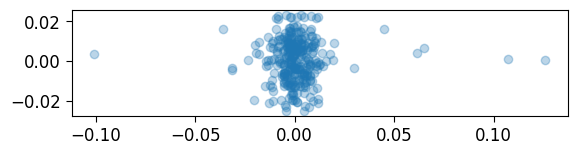

In [863]:
plt.scatter(a_off_dig, b_off_dig, alpha=0.3)
ax = plt.gca()
ax.set_aspect("equal")
# ax.plot([-1,1],[-1,1])

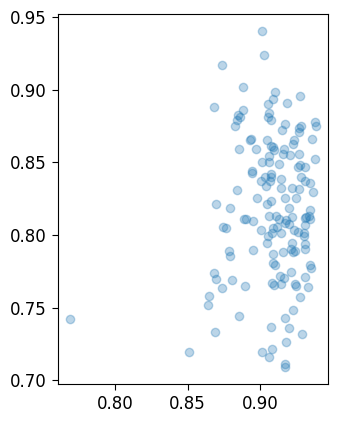

In [862]:
plt.scatter(a_dig, b_dig, alpha=0.3)
ax = plt.gca()
ax.set_aspect("equal")
# ax.plot([12,15],[12,15])

In [ ]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol



In [ ]:
# Initialize atoms object and attach calculator.
atoms = ase.Atoms(valid_batches[4]['Z'], valid_batches[4]['R'])
# atoms.set_calculator(MessagePassingCalculator())

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

In [ ]:
# Initialize atoms object and attach calculator.
atoms = ase.Atoms(valid_batches[5]['Z'], valid_batches[5]['R'])
# atoms.set_calculator(MessagePassingCalculator())

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()